[View in Colaboratory](https://colab.research.google.com/github/kyokicchi/python_textAnalysis/blob/master/textAnalysis.ipynb)

In [3]:
!pip install pyquery

    100% |████████████████████████████████| 5.8MB 2.8MB/s 


In [0]:
import urllib.request
from pyquery import PyQuery as pq


url = 'https://www.aozora.gr.jp/cards/000035/files/301_14912.html'
with urllib.request.urlopen(url) as response:
    html = response.read()
query = pq(html,  parser='html')

text = query(".main_text").text().replace('\n', '')
texts = text.split('。')
texts = [text_+'\n' for text_ in texts]

with open('raw.txt', 'w', encoding='utf-8') as file:
    file.writelines(texts)

はしがき私は、その男の写真を三葉、見たことがある
一葉は、その男の、幼年時代、とでも言うべきであろうか、十歳前後かと推定される頃の写真であって、その子供が大勢の女のひとに取りかこまれ、（それは、その子供の姉たち、妹たち、それから、従姉妹（いとこ）たちかと想像される）庭園の池のほとりに、荒い縞の袴（はかま）をはいて立ち、首を三十度ほど左に傾け、醜く笑っている写真である
醜く？　けれども、鈍い人たち（つまり、美醜などに関心を持たぬ人たち）は、面白くも何とも無いような顔をして、「可愛い坊ちゃんですね」といい加減なお世辞を言っても、まんざら空（から）お世辞に聞えないくらいの、謂（い）わば通俗の「可愛らしさ」みたいな影もその子供の笑顔に無いわけではないのだが、しかし、いささかでも、美醜に就いての訓練を経て来たひとなら、ひとめ見てすぐ、「なんて、いやな子供だ」と頗（すこぶ）る不快そうに呟（つぶや）き、毛虫でも払いのける時のような手つきで、その写真をほうり投げるかも知れない
まったく、その子供の笑顔は、よく見れば見るほど、何とも知れず、イヤな薄気味悪いものが感ぜられて来る
どだい、それは、笑顔でない


In [9]:
!pip install janome

    100% |████████████████████████████████| 20.0MB 627kB/s 
  Running setup.py bdist_wheel for janome ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/53/60/be/fe884e2d0ebc9fec0988736cf08a2820ab34e3569fc0c5a25a
Successfully built janome


In [0]:
from janome.charfilter import *
from janome.analyzer import Analyzer
from janome.tokenizer import Tokenizer
from janome.tokenfilter import *

with open('raw.txt', 'r', encoding='utf-8') as file:
    texts = file.readlines()
texts = [text_.replace('\n', '') for text_ in texts]


char_filters = [UnicodeNormalizeCharFilter(),         # UnicodeをNFKC(デフォルト)で正規化
                RegexReplaceCharFilter('\(', ''),     # (を削除
                RegexReplaceCharFilter('\)', '')      # )を削除
                ]

# 単語に分割
tokenizer = Tokenizer()


#
# 名詞中の数(漢数字を含む)を全て0に置き換えるTokenFilterの実装
#
class NumericReplaceFilter(TokenFilter):

    def apply(self, tokens):
        for token in tokens:
            parts = token.part_of_speech.split(',')
            if (parts[0] == '名詞' and parts[1] == '数'):
                token.surface = '0'
                token.base_form = '0'
                token.reading = 'ゼロ'
                token.phonetic = 'ゼロ'
            yield token


#
#  ひらがな・カタガナ・英数字の一文字しか無い単語は削除
#
class OneCharacterReplaceFilter(TokenFilter):

    def apply(self, tokens):
        for token in tokens:
            # 上記のルールの一文字制限で引っかかった場合、その単語を無視
            if re.match('^[あ-んア-ンa-zA-Z0-9ー]$', token.surface):
                continue

            yield token


# 単語に対する処理のまとめ
token_filters = [NumericReplaceFilter(),                         # 名詞中の漢数字を含む数字を0に置換
                 CompoundNounFilter(),                           # 名詞が連続する場合は複合名詞にする
                 POSKeepFilter(['名詞', '動詞', '形容詞', '副詞']),# 名詞・動詞・形容詞・副詞のみを取得する
                 LowerCaseFilter(),                              # 英字は小文字にする
                 OneCharacterReplaceFilter()                     # 一文字しか無いひらがなとカタガナと英数字は削除
                 ]

analyzer = Analyzer(char_filters, tokenizer, token_filters)


tokens_list = []
raw_texts = []
for text in texts:
    # 文を分割し、単語をそれぞれ正規化する
    text_ = [token.base_form for token in analyzer.analyze(text)]
    if len(text_) > 0:
        tokens_list.append([token.base_form for token in analyzer.analyze(text)])
        raw_texts.append(text)

# 正規化された際に一文字もない文の削除後の元テキストデータ
raw_texts = [text_+'\n' for text_ in raw_texts]
with open('editted.txt', 'w', encoding='utf-8') as file:
    file.writelines(raw_texts)

# 単語リストの作成
words = []
for text in tokens_list:
    words.extend([word+'\n' for word in text if word != ''])

with open('wordslist.txt', 'w', encoding='utf-8') as file:
    file.writelines(words)
    
    


In [17]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 5.5MB/s 


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


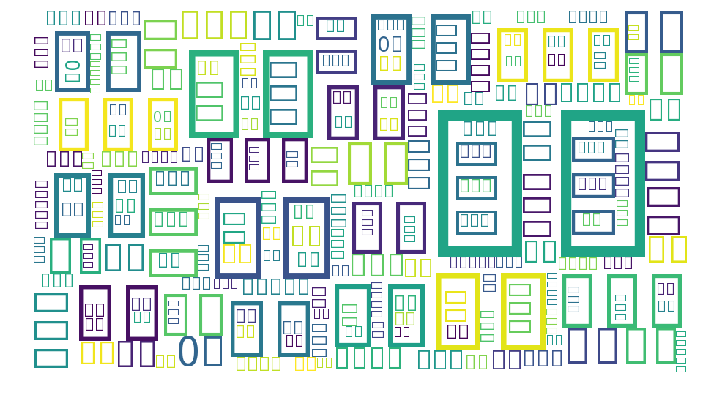

In [27]:
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib



with open('wordslist.txt', 'r', encoding='utf-8') as file:
    text = file.readlines()
text = ' '.join(text).replace('\n', '')



# ストップワードの設定
# ここで設定した単語はWord Cloudに表示されない
stop_words = [u'てる', u'いる', u'なる', u'れる', u'する', u'ある', u'こと', u'これ', u'さん', u'して', \
              u'くれる', u'やる', u'くださる', u'そう', u'せる', u'した', u'思う', \
              u'それ', u'ここ', u'ちゃん', u'くん', u'', u'て', u'に', u'を', u'は', u'の', u'が', u'と', u'た', u'し', u'で', \
              u'ない', u'も', u'な', u'い', u'か', u'ので', u'よう', u'', u'もの', u'もつ']

matplotlib.rc('font', family='Noto Sans CJK JP')

wordcloud = WordCloud(background_color="white",
                      width=900,
                      height=500,
                      stopwords=set(stop_words)).generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.savefig('cloud.png')
plt.show()


